In [1]:
import sys
import os
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib
import toml
import time
from ipywidgets import *
import cv2
import uuid
from absl import logging
logging.set_verbosity(0)

import copy
import os
import json

from datetime import datetime

In [2]:
import sys
sys.path.append("/home/anujraaj/mule")

In [3]:
from lc_utils import load_imu_data
from submap import Submap
from lc_utils import combine_yelli_poses, get_inverse_yelli_pose, imu_pose_estimate, normalize_pose

In [4]:
from ati.perception.lidar import lidar_pb, lidar_utils
from ati.perception.lidar.lidar_voxel import voxel_filter
from ati.perception.utils.voxel_filter_utils import voxel_filter_fast
from ati.perception.lidar.lidar_frame import *
from ati.slam.yelli import utils, grid
from utils.imu_tracker import ImuTracker

data [0.3 0.7 0.9 0.3 0.6 0.2 0.8 0.6 0.2 0.8 0.8 0.7 0.9 0.1 0.1]
unique [0.1 0.2 0.3 0.6 0.7 0.8 0.9]
sorted [0.1 0.1 0.2 0.2 0.3 0.3 0.6 0.6 0.7 0.7 0.8 0.8 0.8 0.9 0.9]
indices of unique values [ 0  2  4  6  8 10 13]
argsort [13 14  5  8  0  3  4  7  1 11  6  9 10  2 12]


## Submap Generation

In [5]:
max_frames = 32000 
# data_dir = "/atidata/demo/SLLumax/2021-07/21-07-2021/map_raw_data/2021-07-21-10-50-46-mini20-02-manual-sllmax_map/"
data_dir =r"/atidata/customer/Bosch/2021-08-30-16-24-40-minimule-11-3-manual-Bosch-32beam_capture_2"
data_dir=r"/Users/anujraaj/robotics/SLAM-loop-closure/data/indoor-run/2021-12-29-11-52-57-minimule-11-2-manual-bosch_nashik_indoor"
data_dir=r"/Users/anujraaj/robotics/SLAM-loop-closure/data/2021-11-11-15-31-42-minimule-11-2-manual-floor_1__mapping"
data_dir=r"/atidata/customer/Flipkart_Malur_Impl/floor-Gplus1-repeat-32beams/2021-11-11-15-31-42-minimule-11-2-manual-floor_1__mapping/"
data_dir = "/atidata/customer/Flipkart_Malur_Impl/floor-Gplus1-repeat-32beams/2021-11-11-15-31-42-minimule-11-2-manual-floor_1__mapping/"
data_dir = r"/atidata/demo/SLLumax/2021-07/21-07-2021/map_raw_data/2021-07-21-10-50-46-mini20-02-manual-sllmax_map"

In [6]:
bootstrap_frames =20

grid_res = 0.05 
grid_alpha =1
num_submap_range_data = 90
alpha= 1.05
start_frame = 50

grid_params = {
    "x": (-0.1, 0.1),
#    "x": (-0.2, 0.2),
#    "x": (-0.4, 0.4),
#    "y": (-0.02, 0.30),
    "y": (-0.20, 0.30),
#    "y": (-0.40, 0.60),
    "theta": (-0.2, 0.2),
#    "num_x": 11,
#    "num_x": 22,
#    "num_x": 44,
#    "num_y": 17,
#    "num_y" : 26,
#    "num_y" : 52,
#    "num_t": 41,
    "num_t": 61,
    
}

grid_params['num_x'] = int((grid_params['x'][1] - grid_params['x'][0])/grid_res + 1)
grid_params['num_y'] = int((grid_params['y'][1] - grid_params['y'][0])/grid_res + 1)



zmin, zmax = 0.3, 2.0

In [7]:
z_slices = [(zmin,zmax)]
print("Using Z slices:", z_slices)

Using Z slices: [(0.3, 2.0)]


In [8]:
imu_data = load_imu_data(data_dir)
imu_tracker = ImuTracker()
imu_bias_initialized = False
i = 0
while not imu_bias_initialized:
    imu_bias_initialized = imu_tracker.get_initial_gyro_bias(imu_data.iloc[i])
    i += 1


In [9]:
pose = np.array([0.,0., np.pi/2])
prev_pose = pose.copy()
spose = pose #local submap pose

In [10]:
submaps, active_submaps, finished_submaps = [], [], [] #active_submaps contain two two at a time -- implementation for overlapping submaps
best_scores = []
node_poses = [] #? poses of inserted frames in the global frame
inserted_frame_ids=[] #frame_id for inserted frame
submap = Submap(spose.copy(), grid_res, grid_alpha)
active_submaps.append(submap)

In [11]:
count_once = True

In [12]:
try:
    lpb = lidar_pb.LidarSmallPb(data_dir)
except:
    lpb = lidar_pb.LidarPb(data_dir)
prev_frame_time, prev_frame = lpb.get_frame(start_frame - 2)
num_frames = np.minimum(len(lpb.list_frames()), max_frames)
print(f"total frames {num_frames}")
for frame_id in range(start_frame, num_frames - 1):
    #if frame_id % 2 != 0:
        #continue
    try:
        frame_time, frame = lpb.get_frame(frame_id)
    except:
        print(f"skipping {frame_id}. divide-by-zero error")
        continue

    frame = np.copy(frame[:, :6]).astype(np.float64)
    frame = frame[(frame[:,4]>0) & (frame[:,4] < 60)]
    frame = frame[(frame[:,2] > zmin) & (frame[:,2] < zmax)]
    #filtered_frame = voxel_filter(frame, voxel_size=0.05)
    filtered_frame,_ = voxel_filter_fast(voxel_filter(frame, voxel_size=0.05), trunc=False, voxel = 0.25)
    frame_z = voxel_filter(frame[:,:3], voxel_size=0.05)
    
    if frame_id < start_frame + bootstrap_frames:
        print("Num Bootstrap insertions", active_submaps[0].num_insertions)
        spose = combine_yelli_poses(pose, get_inverse_yelli_pose(active_submaps[0].pose)) # pose wrt submap origin
        node_poses.append(pose)
        inserted_frame_ids.append(frame_id)
        active_submaps[0].insert_points(frame_z, spose, frame_id, node_id = len(node_poses)-1 )
#         frame_list.append(frame_id)
#         poses.append(pose)
        prev_insert_ts = frame_time
        prev_frame_time, prev_frame = frame_time, frame
        last_inserted_pose = pose.copy()
        continue
    
    #HACK
    #skip if vehicle is not moving. Skip?
    
    relevant_imu_data = imu_data[imu_data["time"].between(prev_frame_time, frame_time)]
    for imu_idx in range(relevant_imu_data.shape[0]):
        imu_tracker.add_imu_data(relevant_imu_data.iloc[imu_idx])
    
    pose_estimate = imu_pose_estimate(imu_tracker, frame_time, pose) #only theta around which we need to search changes
    spose_estimate = combine_yelli_poses(get_inverse_yelli_pose(active_submaps[0].pose),pose_estimate)
    search_space = utils.grid_space(center=spose_estimate, **grid_params)
    
    if count_once is True:
        scores,n_unique_visited_points = active_submaps[0].search(filtered_frame, search_space, count_once = True)
        scores = scores/n_unique_visited_points
    else:
        scores = active_submaps[0].search(filtered_frame, search_space, count_once = False)
    
    best = np.argmax(scores)
    best_scores.append(scores[best])
    
    spose = search_space[best]
    pose = combine_yelli_poses(active_submaps[0].pose, spose)
    
    #HACK
    if len(frame_z) < 500:
        continue
    #Check all quadrants have points
    if (np.sum((frame_z[:,0] < 0) & (frame_z[:,1] > 0)) <10) or \
    (np.sum((frame_z[:,0] < 0) & (frame_z[:,1] < 0)) <10) or \
    (np.sum((frame_z[:,0] > 0) & (frame_z[:,1] > 0)) <10) or \
    (np.sum((frame_z[:,0] > 0) & (frame_z[:,1] < 0)) <10):
        continue
    
    if (np.linalg.norm(pose[:2]-last_inserted_pose[:2])> 0.15 or (prev_insert_ts - frame_time)>1) :
        node_poses.append(pose)
        inserted_frame_ids.append(frame_id)
        active_submaps[0].insert_points(frame_z, spose, frame_id, node_id=len(node_poses)-1)
        if len(active_submaps) ==1:
        
            if active_submaps[0].num_insertions >= int(num_submap_range_data/2):
                active_submaps.append(Submap(pose.copy(), grid_res, grid_alpha))
                s2pose = combine_yelli_poses(get_inverse_yelli_pose(active_submaps[1].pose),pose)
                active_submaps[1].insert_points(frame_z,s2pose, frame_id, node_id=len(node_poses)-1)
                #print(f"spose {spose}, s2pose {s2pose}")
                
        else:
            
            s2pose = combine_yelli_poses(get_inverse_yelli_pose(active_submaps[1].pose),pose)
            active_submaps[1].insert_points(frame_z,s2pose, frame_id, node_id=len(node_poses)-1)
            #print(f"len else spose {spose}, s2pose {s2pose}")
            
        if active_submaps[0].num_insertions >= num_submap_range_data - 1:
            active_submaps[0].finish()
            finished_submaps.append(active_submaps.pop(0))
            active_submaps.append(Submap(pose.copy(), grid_res, grid_alpha))
            s2pose = combine_yelli_poses(get_inverse_yelli_pose(active_submaps[1].pose), pose)
            active_submaps[1].insert_points(frame_z,s2pose, frame_id, node_id=len(node_poses)-1)
        
        #print("num active submaps", len(active_submaps))
        prev_insert_ts = frame_time
        last_inserted_pose = pose.copy()
    if frame_id % 250 == 0:
        print(f"frame:{frame_id} scores:{best_scores[-1]} best pose:{pose}  ")
    prev_frame_time, prev_frame = frame_time, frame
node_poses = np.array(node_poses)
inserted_frame_ids = np.array(inserted_frame_ids)
# print(f"final pose {poses[-1]}")
    

total frames 10012
Num Bootstrap insertions 0
Num Bootstrap insertions 1
Num Bootstrap insertions 2
Num Bootstrap insertions 3
Num Bootstrap insertions 4
Num Bootstrap insertions 5
Num Bootstrap insertions 6
Num Bootstrap insertions 7
Num Bootstrap insertions 8
Num Bootstrap insertions 9
Num Bootstrap insertions 10
Num Bootstrap insertions 11
Num Bootstrap insertions 12
Num Bootstrap insertions 13
Num Bootstrap insertions 14
Num Bootstrap insertions 15
Num Bootstrap insertions 16
Num Bootstrap insertions 17
Num Bootstrap insertions 18
Num Bootstrap insertions 19
frame:250 scores:0.5570014270328127 best pose:[0.         0.         1.57119782]  
frame:500 scores:0.47750402625956584 best pose:[0.00165198 0.79999787 1.56861686]  
frame:750 scores:0.5653618476062461 best pose:[-0.64649142 13.08086114  1.61530045]  
frame:1000 scores:0.6106957522518711 best pose:[-0.77247917 19.87294715  1.54495186]  
frame:1250 scores:0.5093796101728784 best pose:[-0.89230555 24.41997403  1.58721101]  
fram

### Saving and Plotting generated Submaps

In [57]:
# node_poses

In [13]:
import pickle

with open("maps/SLL/1/submaps-node_poses-inserted_frame_ids_countonce.pickle", 'wb') as f:
    pickle.dump((finished_submaps, node_poses, inserted_frame_ids),f)

In [14]:
# with open("maps/2/submaps-node_poses-inserted_frame_ids.pkl", 'rb') as f:
#     random = pickle.load(f)

<IPython.core.display.Javascript object>


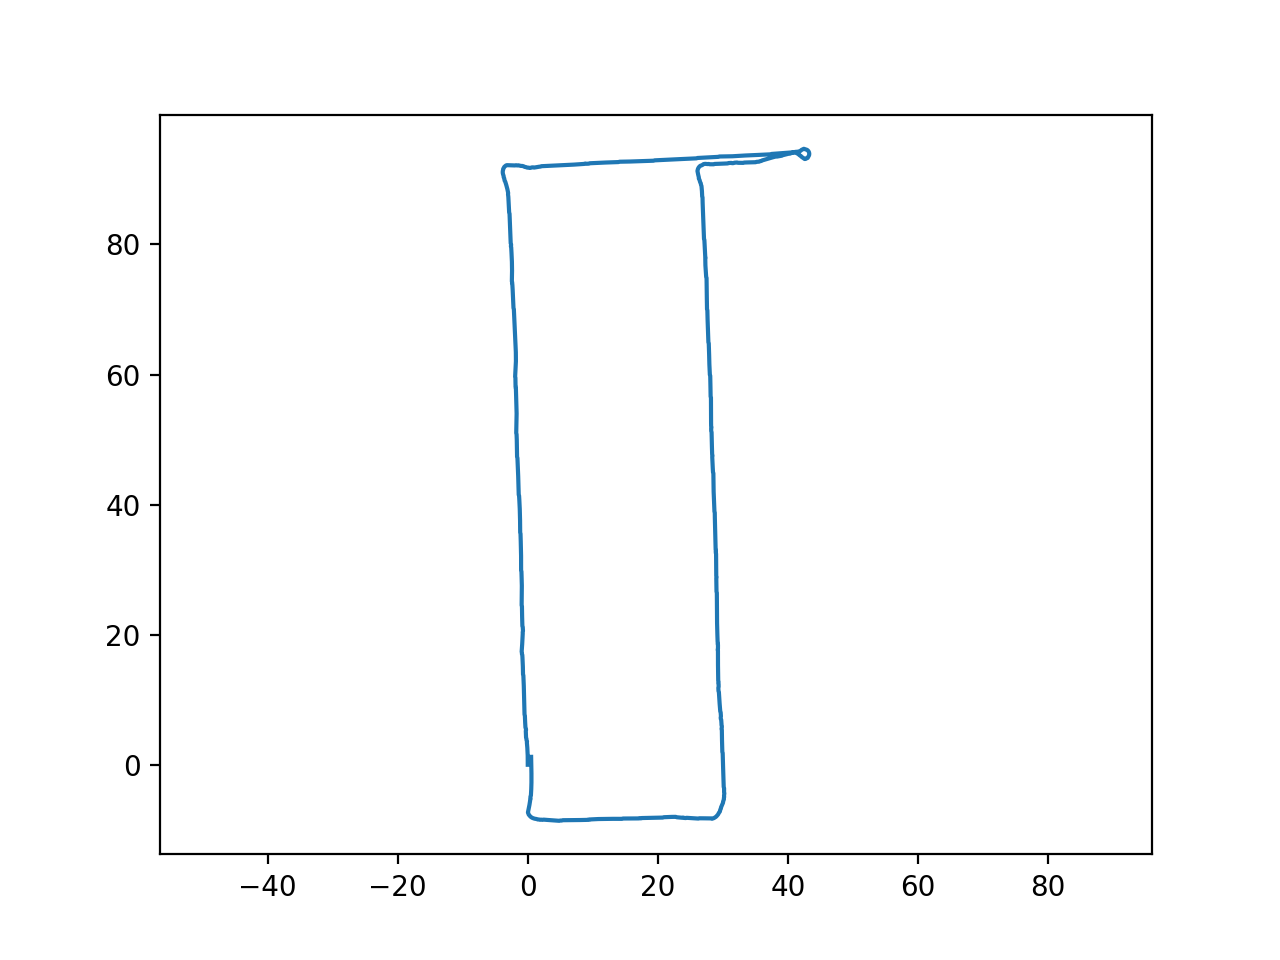

(-6.202463905333008,
 45.640790126911405,
 -13.784182966052873,
 99.87543609035242)

In [21]:
node_poses = np.array(node_poses)
st = 0; stp = -1
plt.figure()
plt.plot(node_poses[st:stp,0], node_poses[st:stp,1], )
plt.axis('equal')


In [22]:
# node_poses

<IPython.core.display.Javascript object>


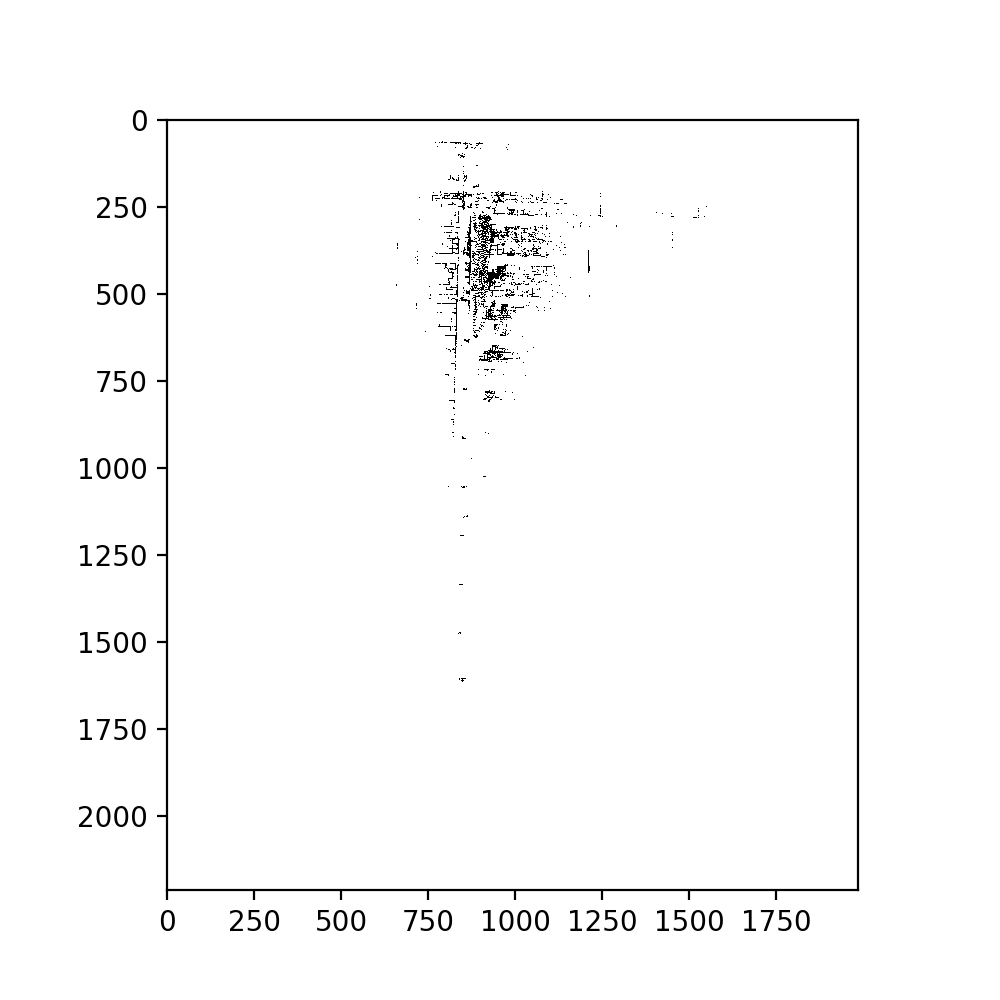

In [23]:
# %matplotlib inline
%matplotlib notebook
# %matplotlib notebook
plt.figure(figsize = (5,5))
#plt.imshow(1-(finished_submaps[2].grid.grid.T> 0), cmap='gray') 
if finished_submaps[0].iscompressed:
        finished_submaps[0].decompress_data()
plt.imshow(1 - (finished_submaps[0].grid.grid.T>0), cmap='gray') 
#print(np.sum(finished_submaps[1].grid.grid >0))

In [24]:
print( len(finished_submaps), len(node_poses), len(inserted_frame_ids))

33 1535 1535


# Finding Constraints

In [25]:
import branch_bound as bb
from importlib import reload
from constraint import Constraint
import pg

reload(bb)
reload(pg)

<module 'pg' from '/home/anujraaj/robo/SLAM-loop-closure/pg.py'>

### Version-1: Find constraints altogether at the end.

In [39]:
x_search_window = (-5,5)
y_search_window = (-5,5)
angle_search_window = (-np.pi/6, np.pi/6)
score_th=0.5
dist_th = 10
node_dists = np.cumsum(np.linalg.norm(node_poses[1:,:2]-node_poses[:-1,:2], axis = 1))
node_dists = np.concatenate(([0],node_dists))
print(len(node_dists), len(node_poses))

1535 1535


In [40]:
constraints=[]
for sid in range(len(finished_submaps)):
    submap = finished_submaps[sid]
    if submap.iscompressed:
        submap.decompress_data()
    hgrids =  bb.compute_hierarchical_grid(submap.grid, num_levels=4)
    for nid in range(len(node_poses)):
        npose = node_poses[nid]
        dist = np.linalg.norm(npose[:2] - submap.pose[:2])
        node_dist = abs(node_dists[nid] - node_dists[submap.node_ids[0]])
        if node_dist < 20:
            continue
        if nid not in submap.node_ids and (dist < dist_th):
            fr_id = inserted_frame_ids[nid]
            ts, frame = lpb.get_frame(fr_id)
            frame = np.copy(frame[:, :6]).astype(np.float64)
            frame = frame[(frame[:,4]>0) & (frame[:,4] < 60)]
            frame = frame[(frame[:,2] > zmin) & (frame[:,2] < zmax)]
            frame_z = voxel_filter(frame[:,:3], voxel_size=0.05)
            if len(frame_z) < 500:
                continue
            #Check all quadrants have points
            if (np.sum((frame_z[:,0] < 0) & (frame_z[:,1] > 0)) <10) or \
            (np.sum((frame_z[:,0] < 0) & (frame_z[:,1] < 0)) <10) or \
            (np.sum((frame_z[:,0] > 0) & (frame_z[:,1] > 0)) <10) or \
            (np.sum((frame_z[:,0] > 0) & (frame_z[:,1] < 0)) <10):
                continue
            frame_z,_ = voxel_filter_fast(frame_z, trunc=False, voxel = 0.25)  
            
            spose_estimate = combine_yelli_poses(get_inverse_yelli_pose(submap.pose), npose)
            hpose, hscore = bb.hierarchical_search(hgrids, spose_estimate, frame_z,
                                        x_search_window,y_search_window,angle_search_window
                                        ,count_once=True, max_range = 60, score_th = score_th, debug=False)
            if hpose is not None:    
                print("sid, nids, pose, score: ",[submap.node_ids[0], nid], hpose, hscore)
                constraints.append(Constraint([submap.node_ids[0], nid], hpose))
    print(f"Submap {sid} done..")
    submap.compress_data()

sid, nids, pose, score:  [0, 1520] [ 0.05785319 -1.51622096  1.57662323] 0.5157101252323484
sid, nids, pose, score:  [0, 1522] [ 0.05074789 -1.12026672  1.58771743] 0.5218428024887987
Submap 0 done..
Submap 1 done..
Submap 2 done..
Submap 3 done..
Submap 4 done..
Submap 5 done..
Submap 6 done..
Submap 7 done..
Submap 8 done..
Submap 9 done..
Submap 10 done..
Submap 11 done..
Submap 12 done..
Submap 13 done..
sid, nids, pose, score:  [616, 796] [ 0.87339185  9.57599246 -1.55996983] 0.6230548839847387
sid, nids, pose, score:  [616, 797] [ 0.97781     9.42959973 -1.54584958] 0.5898834627478049
sid, nids, pose, score:  [616, 803] [ 0.92199587  8.2884547  -1.57044909] 0.5960978102360444
sid, nids, pose, score:  [616, 804] [ 0.90845944  8.07817623 -1.57028032] 0.6283294626215143
sid, nids, pose, score:  [616, 805] [ 0.90627907  7.77756626 -1.59304232] 0.5568920535509353
sid, nids, pose, score:  [616, 806] [ 1.06311889  7.54722718 -1.54456892] 0.5330203033378845
sid, nids, pose, score:  [616,

Submap 18 done..
Submap 19 done..
Submap 20 done..
Submap 21 done..
Submap 22 done..
Submap 23 done..
Submap 24 done..
Submap 25 done..
Submap 26 done..
Submap 27 done..
Submap 28 done..
Submap 29 done..
Submap 30 done..
Submap 31 done..
Submap 32 done..


In [41]:
import pickle
with open("./maps/5/constraints_oneshot_3.pickle", 'wb') as f:
    pickle.dump(constraints,f)
#pickle.dump(constraints,"./cons.pickle")

In [42]:
len(finished_submaps), len(constraints)

(33, 86)

### linear pose graph

In [31]:
g2o_nps = node_poses.copy()
for i in range(len(node_poses)):
    g2o_nps[i,2] = normalize_pose(node_poses[i,2]- np.pi/2)

g2o_cons = constraints
for i in range(len(constraints)):
    g2o_cons[i].relative_pose[2] = normalize_pose(constraints[i].relative_pose[2] - np.pi/2)
ps = pg.PoseGraphOptimization()
for i in range(len(g2o_nps)):
    if i == 0:
        ps.add_vertex(i, g2o_nps[i], fixed = True)
    else:
        ps.add_vertex(i, g2o_nps[i])
for i in range(len(g2o_nps)-1):
    ps.add_edge_from_state([i,i+1], information=np.identity(3))
for i in range(len(g2o_cons)-1):
    #print(i, g2o_cons[i].relative_pose)
    constraint = g2o_cons[i]
    ps.add_edge(constraint.node_ids, constraint.relative_pose, information= 1 *np.identity(3))
    
ps.optimize()
oposes=[]
for i in range(len(g2o_nps)):
    oposes.append(ps.get_pose(i).vector())
oposes = np.array(oposes)

### flower pose-graph

In [43]:
from copy import deepcopy
g2o_nps = deepcopy(node_poses)
for i in range(len(node_poses)):
    g2o_nps[i,2] = normalize_pose(node_poses[i,2]- np.pi/2)

g2o_cons = deepcopy(constraints)
for i in range(len(constraints)):
    g2o_cons[i].relative_pose[2] = normalize_pose(constraints[i].relative_pose[2] - np.pi/2)

last_nid = finished_submaps[-1].node_ids[-1]
ps = pg.PoseGraphOptimization()
cdist_th = 1
#for i in range(len(g2o_nps)):
for i in range(last_nid+1):
    if i == 0:
        ps.add_vertex(i, g2o_nps[i], fixed = True)
    else:
        ps.add_vertex(i, g2o_nps[i])

for si in range(len(finished_submaps)):
    s = finished_submaps[si]
    snid = s.node_ids[0]
    for ni in s.node_ids[1:]:
        ps.add_edge_from_state([snid, ni], information = np.identity(3))
for i in range(len(g2o_cons)):
    #print(i, g2o_cons[i].relative_pose)
    constraint = g2o_cons[i]
    if np.linalg.norm(constraint.relative_pose[:2]) < cdist_th:
        ps.add_edge(constraint.node_ids, constraint.relative_pose, information= 1 * np.identity(3))
    
ps.optimize()
oposes=[]
#for i in range(len(g2o_nps)):
for i in range(last_nid+1):
    oposes.append(ps.get_pose(i).vector())
oposes = np.array(oposes)

In [44]:
oposes

array([[ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       ...,
       [ 0.22355897, -6.36539983, -0.19216335],
       [ 0.26132312, -6.16899772, -0.18755543],
       [ 0.29635682, -5.97209503, -0.16582331]])

<IPython.core.display.Javascript object>


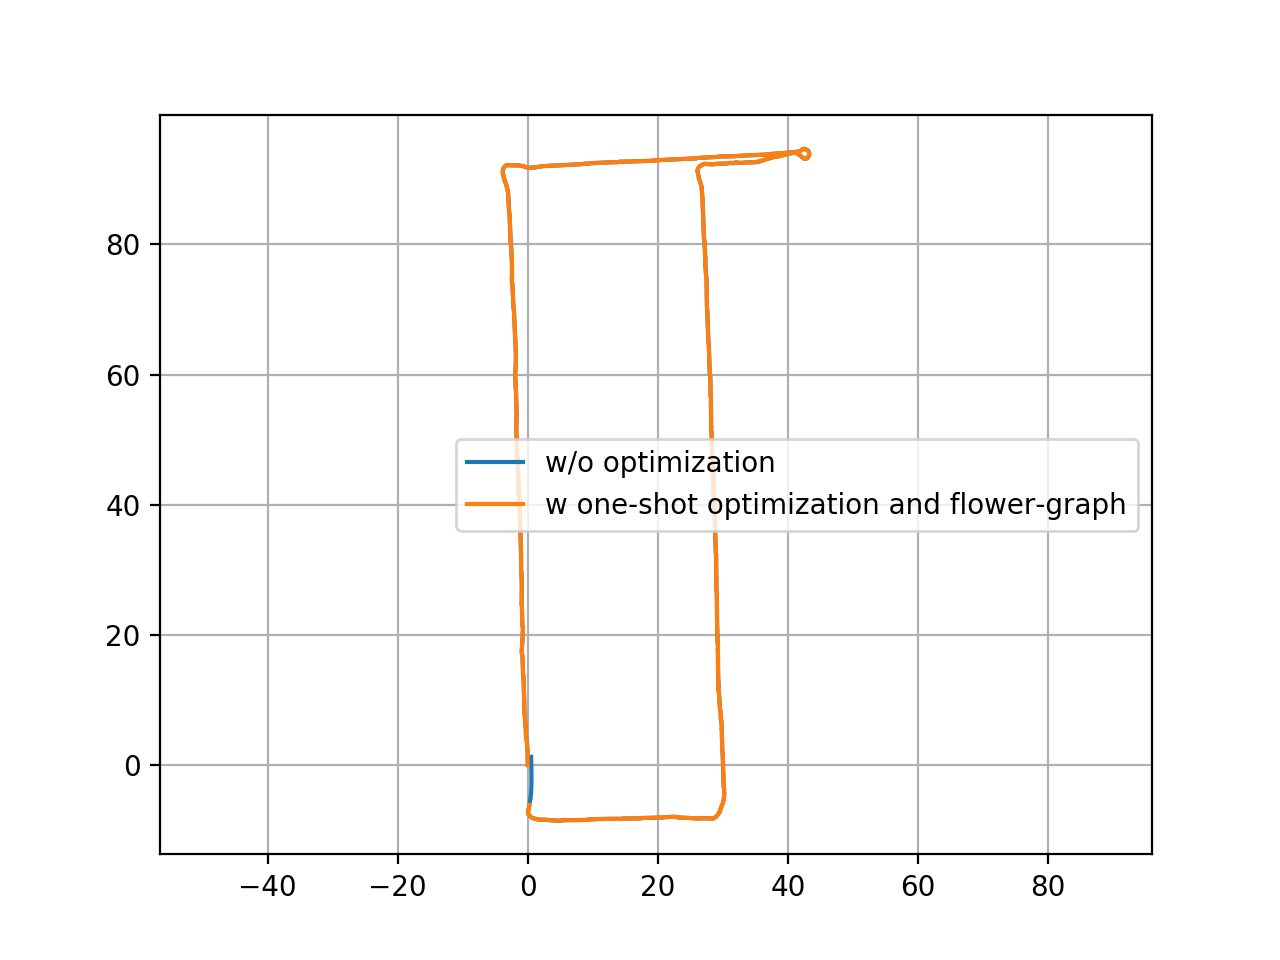

In [47]:
node_poses = np.array(node_poses)
st = 0; stp = -1
plt.figure()
plt.plot(node_poses[st:stp,0], node_poses[st:stp,1], label="w/o optimization" )
plt.plot(oposes[st:stp,0], oposes[st:stp,1], label="w one-shot optimization and flower-graph")
plt.axis('equal')
plt.legend()
plt.grid()

In [56]:
import pickle
with open("./maps/5/oposes_3.pickle",'wb') as f:
    pickle.dump(oposes,f)

### Visualize

### Version-2: Run Optimization iteratively as you find constraints

In [ ]:
temp_poses = copy.deepcopy(node_poses)
dist_th = 10
x_search_window = (-5,5)
y_search_window = (-5,5)
angle_search_window = (-np.pi/6, np.pi/6)
score_th = 0.7
cdist_th = 1.5
constraints = []
use_flower_pg = True
cscores = []
prev_node_dist = 0

for sid in range(0,len(finished_submaps)):
    submap = finished_submaps[sid]
    if submap.iscompressed:
        submap.decompress_data()
    hgrids = bb.compute_hierarchical_grid(submap.grid, num_levels = 4)
    
    for nid in range(0, submap.node_ids[-1]):
        npose = temp_poses[nid]
        spose = temp_poses[submap.node_ids[0]]
        dist = np.linalg.norm(npose[:2] - spose[:2])
        node_dist = abs(node_dists[nid] - node_dists[submap.node_ids[0]])
        if node_dist < 20:
            continue
        if abs(node_dists[nid]-prev_node_dist) < 0.25:
            continue
        prev_node_dist = node_dists[nid]
        if nid not in submap.node_ids and (dist < dist_th):
            print(nid)
            fr_id = insertion_fr_ids[nid]
            ts, frame = lpb.get_frame(fr_id)
            frame = np.copy(frame[:, :6]).astype(np.float64)
            frame = frame[(frame[:,4]>0) & (frame[:,4] < 60)]
            frame = frame[(frame[:,2] > zmin) & (frame[:,2] < zmax)]
            frame_z = voxel_filter(frame[:,:3], voxel_size=0.05)
            if len(frame_z) < 500:
                continue
            #Check all quadrants have points
            if (np.sum((frame_z[:,0] < 0) & (frame_z[:,1] > 0)) <10) or \
            (np.sum((frame_z[:,0] < 0) & (frame_z[:,1] < 0)) <10) or \
            (np.sum((frame_z[:,0] > 0) & (frame_z[:,1] > 0)) <10) or \
            (np.sum((frame_z[:,0] > 0) & (frame_z[:,1] < 0)) <10):
                continue
            frame_z,_ = voxel_filter_fast(frame_z, trunc=False, voxel = 0.25)  
            
            spose_estimate = combine_yelli_poses(get_inverse_yelli_pose(spose), npose)
            hpose, cscore = hierarchical_search(hgrids, spose_estimate, frame_z,
                                        x_search_window,y_search_window,angle_search_window
                                        , max_range = 60, score_th = score_th)

            if hpose is not None: 
                thpose = combine_yelli_poses(spose, hpose)
                mid_pose = temp_poses[submap.node_ids[45]]
                dthpose = thpose[:2] - mid_pose[:2]
                #print(dthpose, spose, mid_pose)
                if np.linalg.norm(dthpose[:2]) > cdist_th:
                    print("Crossed cdist_th .Skipping...",np.linalg.norm(dthpose[:2]))
                    continue
                print("sid, nids, pose, cscore",[submap.node_ids[0], nid], hpose, cscore)
                print("Doing pose graph optimization")
                ps = PoseGraphOptimization()
                for i in range(0,submap.node_ids[-1] + 1 ):
                #for i in range(0,len(temp_poses)):
                    pgpose = temp_poses[i].copy()
    
                    pgpose[2] = normalize_pose(pgpose[2]- np.pi/2)
                    if i == 0:                        
                        ps.add_vertex(i, pgpose, fixed = True)
                    else:
                        ps.add_vertex(i, pgpose)
                    
                #for i in range(0,submap.node_ids[-1] + 1):
                #for i in range(0,nid+1):
                #for i in range(0,len(temp_poses)- 1):
                #    ps.add_edge_from_state([i,i+1], information=np.identity(3))
                for si in range(0, sid+1):
                    si_nid = finished_submaps[si].node_ids[0]
                    for ni in finished_submaps[si].node_ids[1:]:
                        ps.add_edge_from_state([si_nid, ni], information= np.identity(3))
                
                con_pose = hpose.copy()
                con_pose[2] = normalize_pose(con_pose[2] - np.pi/2)
                ps.add_edge([submap.node_ids[0], nid], con_pose, information= np.identity(3))
                ps.optimize()
                
                tpose = temp_poses[submap.node_ids[-1]].copy()
                for ti in range(0, submap.node_ids[-1] + 1):
                #for ti in range(0, len(temp_poses[i])):
                    temp_poses[ti] = ps.get_pose(ti).vector()
                    temp_poses[ti,2] = normalize_pose(temp_poses[ti,2] + np.pi/2)
                
                apose = combine_yelli_poses(temp_poses[submap.node_ids[-1]], get_inverse_yelli_pose(tpose) )
                for ti in range(submap.node_ids[-1]+1, len(temp_poses)):
                    temp_poses[ti] = combine_yelli_poses(apose, temp_poses[ti])
                
                constraints.append(Constraint([submap.node_ids[0], nid], hpose))
                cscores.append(cscore)
  
    print(f"Submap {sid} done..")
    submap.compress_data()